In [16]:
import numpy as np
import pandas as pd
from glob import glob
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf
train = pd.read_csv("../../scene-classification/train.csv")

In [17]:
from keras.preprocessing import image

train_image = []
for i in range(train.shape[0]):
#     print(train['image_name'][i])
    img = image.load_img('../../scene-classification/train/'+train['image_name'][i], target_size=(150,150,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

In [18]:
from keras.utils import to_categorical
y=train['label'].values
y = to_categorical(y)

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

# print shape of training set
print('x_train shape:', x_train.shape)
# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (10901, 150, 150, 3)
10901 train samples
3407 test samples
2726 validation samples


In [20]:
from keras.applications.vgg16 import VGG16
# vgg_conv = VGG16(weights = 'imagenet',include_top = False,input_shape = (150,150,3))
# vgg_conv = VGG16(weights = '../../model_weights/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5',
#                  include_top = True,input_shape = (150,150,3))

In [21]:
# vgg_conv.summary()

In [22]:
import tensorflow as tf
# print(tf.__version__)

# for layer in vgg_conv.layers[8:]:
#     layer.trainable = True

# for layer in vgg_conv.layers:
#     print(layer,layer.trainable)

In [23]:
from keras import models,layers,optimizers
model_vgg = models.Sequential()
# model_vgg.add(vgg_conv)
# model_vgg.add(layers.Flatten())
model_vgg.add(layers.Flatten(input_shape=(150,150,3)))
model_vgg.add(layers.Dense(256, activation='relu', input_dim=(150*150*3)))
model_vgg.add(layers.Dense(1024,  activation='relu'))
model_vgg.add(layers.Dropout(0.4))
model_vgg.add(layers.Dense(6,activation = 'softmax'))
model_vgg.load_weights('../../model_weights/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               17280256  
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 6150      
Total params: 17,549,574
Trainable params: 17,549,574
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_vgg.compile(loss='categorical_crossentropy',optimizer = optimizers.RMSprop(lr=1e-4),metrics=['acc'])

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping   

# train the model
# checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='loss')
history = model_vgg.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_valid, y_valid), verbose=1, shuffle=True, callbacks=[earlystopping])


Train on 10901 samples, validate on 2726 samples
Epoch 1/20
10901/10901 [==============================] - 9s 823us/step - loss: 1.6846 - acc: 0.3766 - val_loss: 1.4338 - val_acc: 0.4219
Epoch 2/20
10901/10901 [==============================] - 8s 773us/step - loss: 1.3938 - acc: 0.4445 - val_loss: 1.2560 - val_acc: 0.5033
Epoch 3/20
10901/10901 [==============================] - 8s 778us/step - loss: 1.3254 - acc: 0.4845 - val_loss: 1.3992 - val_acc: 0.4578
Epoch 4/20
10901/10901 [==============================] - 9s 782us/step - loss: 1.2778 - acc: 0.5044 - val_loss: 1.2090 - val_acc: 0.5429
Epoch 5/20
10901/10901 [==============================] - 8s 776us/step - loss: 1.2371 - acc: 0.5191 - val_loss: 1.2312 - val_acc: 0.5282
Epoch 6/20
10901/10901 [==============================] - 9s 781us/step - loss: 1.2031 - acc: 0.5387 - val_loss: 1.2113 - val_acc: 0.5348
Epoch 7/20
10901/10901 [==============================] - 8s 774us/step - loss: 1.1756 - acc: 0.5483 - val_loss: 1.3158 - v

In [26]:
model_vgg.save("../../model_weights/vgg16-places365.h5")

In [27]:
# evaluate and print test accuracy
score = model_vgg.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.5623715879509866


In [28]:
# get predictions on the test set
y_hat = model_vgg.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
classification_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

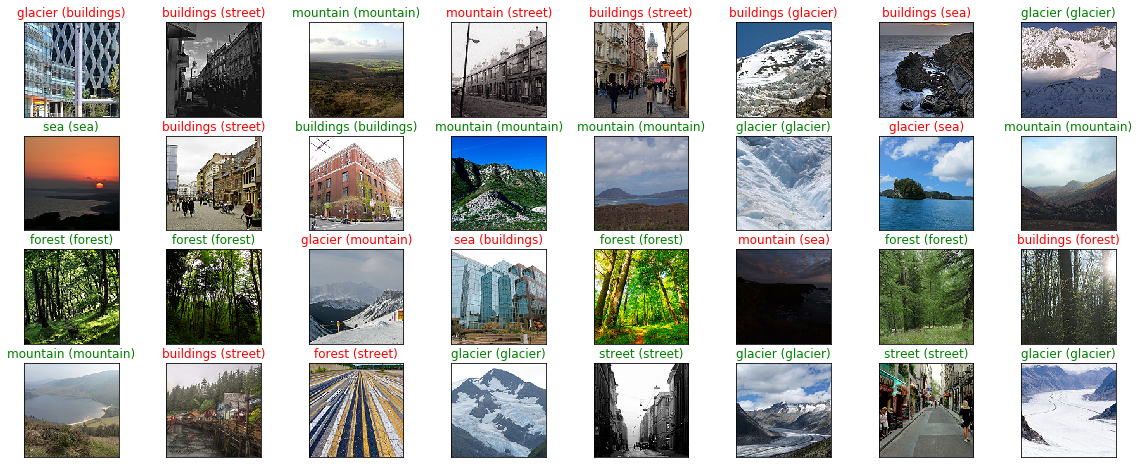

In [29]:
import matplotlib.pyplot as plt
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(classification_labels[pred_idx], classification_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

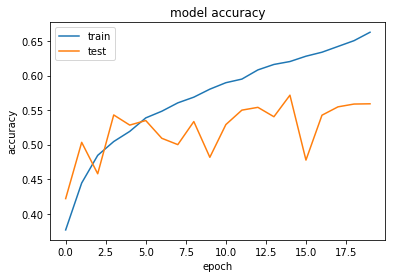

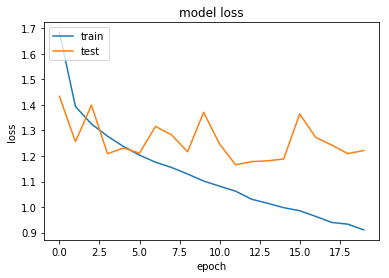

In [30]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()